# USPA lifters by membership type
This page uses data from the OpenPowerlifting project, https://www.openpowerlifting.org. <br>
You may download a copy of the data at https://gitlab.com/openpowerlifting/opl-data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

#### Load the data

In [2]:
data_types = {'Name': str,
              'Sex': str,
              'Equipment': str,
              'Division': str,
              'Event': str,
              'TotalKg': float,
              'Wilks': float,
              'WeightClassKg': str,
              'Federation': str,
              'Place': str,
              'Date': str,
              'MeetState': str,
              'MeetName': str,
              'MeetCountry': str}

columns = ['Name',
           'Sex',
           'Equipment',
           'Division',
           'Event',
           'WeightClassKg',
           'TotalKg',
           'Wilks',
           'Place',
           'Federation',
           'Date',
           'MeetState',
           'MeetName',
           'MeetCountry']

In [3]:
op = pd.read_csv('openpowerlifting-2020-01-03.csv', usecols=columns, dtype=data_types)
op.head()

,Name,Sex,Event,Equipment,Division,WeightClassKg,TotalKg,Place,Wilks,Federation,Date,MeetCountry,MeetState,MeetName
0,Abbie Murphy,F,SBD,Wraps,F-OR,60,290.0,4,324.16,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
1,Abbie Tuong,F,SBD,Wraps,F-OR,60,332.5,2,378.07,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
2,Ainslee Hooper,F,B,Raw,F-OR,56,32.5,1,38.56,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
3,Amy Moldenhauer,F,SBD,Wraps,F-OR,60,310.0,3,345.61,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
4,Andrea Rowan,F,SBD,Wraps,F-OR,110,390.0,3,321.25,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup


#### Analyze the data

In [4]:
# create a year column
op['Year'] = op['Date'].str[0:4].astype(int)

In [5]:
# count U.S. IPL meets as USPA meets
op.loc[(op['MeetCountry'] == 'USA') & (op['Federation'] == 'IPL'), 'Federation'] = 'USPA'

In [6]:
# filter the main dataframe to USPA meets only
uspa = op[(op['Federation'] == 'USPA')]

In [7]:
# find the date of the earliest meet each competitor did each year
# so that a lifter is counted only once per year and so that we can later
# determine their membership status for the year based on their first meet that year
earliest_meet_by_year = uspa.groupby(['Year', 'Name'])['Date'].min().reset_index()

In [8]:
# find the first USPA meet ever for each competitor
first_uspa_meet = uspa.groupby('Name')['Date'].min().reset_index()
first_uspa_meet.columns = ['Name', 'FirstUSPAMeet']

In [9]:
# merge the two dataframes
uspa_data = pd.merge(earliest_meet_by_year, first_uspa_meet, on='Name')

In [10]:
# create a column for membership type
uspa_data['MembershipType'] = 'New'
uspa_data.loc[uspa_data['Date'] > uspa_data['FirstUSPAMeet'], 'MembershipType'] = 'Existing'

In [11]:
# count competitors by membership type
membership = uspa_data.groupby(['Year', 'MembershipType'], as_index=False)['Name'].count()
membership_pivot = membership.pivot_table(index='Year', columns='MembershipType', values='Name', fill_value=0)
membership_pivot

MembershipType,Existing,New
Year,,
2008,0,102
2009,0,41
2010,11,123
2011,65,746
2012,431,1323
2013,720,2003
2014,1169,3291
2015,1885,4046
2016,2760,5896


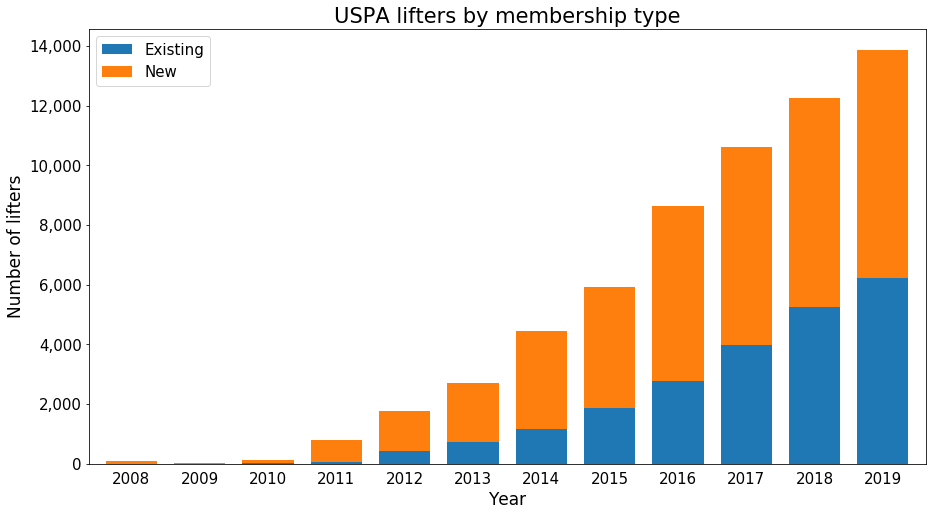

In [12]:
# visualize the results

fig, ax = plt.subplots(figsize=(15, 8))

membership_pivot.plot.bar(stacked=True, width=0.75, ax=ax)

plt.title('USPA lifters by membership type', size=21)
plt.xlabel('Year', size=17)
plt.ylabel('Number of lifters', size=17)
plt.legend(fontsize=15)
plt.xticks(rotation='horizontal', size=15)
ax.tick_params(axis='x', which='major', pad=8, length=0)
plt.yticks(size=15)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()